In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
# z0 (k01) ensemble average
z0avgpath = '/home/aos/ystochel/esm2m/data/processed/MI_hitemp_sens_k01_ensAvg_1950_2100.nc'
ds_z0avg = xr.open_dataset(z0avgpath)
ds_z0avgMean = ds_z0avg.groupby('time.year').mean(dim='time')
ds_z0avgMin = ds_z0avg.groupby('time.year').min(dim='time')

/home/aos/ystochel/miniconda3/envs/esm2m/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/ystochel/miniconda3/envs/esm2m/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [3]:
ds_lim = ds_z0avg.sel(yt_ocean=slice(-30.5,30.5),time=slice('1990-01-01','2100-12-16'))

In [4]:
# Load the area data
rootdir = '/local/ss23/GFDL_LEs/'
subdir = 'AREA_FILES_ETC'
filename_area = 'WOA2001_grid.nc'
path_area = rootdir+subdir+'/'+filename_area
area = xr.open_dataset(path_area)['AREA'].rename({'latitude':'yt_ocean','longitude':'xt_ocean'})
# Fix a slight mismatch in the area LAT and LON coordinates
# Set them to be the same as the temperature dataset 
area = area.assign_coords({'xt_ocean':ds_z0avg['xt_ocean'],'yt_ocean':ds_z0avg['yt_ocean']})

In [5]:
# Calculate the area-weighted mean metabolic index
oceanmask = np.isfinite(ds_z0avg['MI'].isel(time=0).squeeze())
# Set the area variable to nan everwhere there is land, using .where()
area_masked = area.where(oceanmask,np.nan)
# Take the area-weighted mean
mi_mean = (ds_lim['MI']*area_masked).sum(['xt_ocean','yt_ocean'])/(area_masked.sum(['xt_ocean','yt_ocean']))

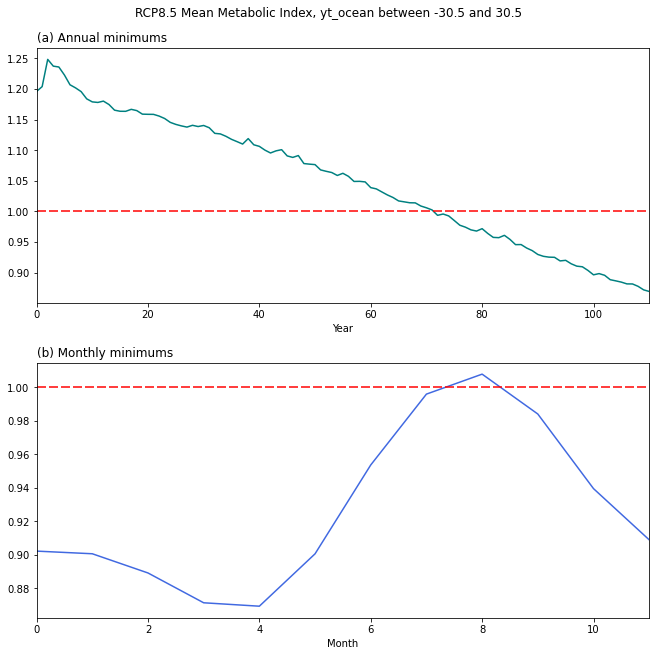

In [6]:
fig,(ax0,ax1) = plt.subplots(figsize=(9,9),nrows=2,constrained_layout=True)
fig.suptitle('RCP8.5 Mean Metabolic Index, yt_ocean between -30.5 and 30.5')
ax0.plot(mi_mean.groupby('time.year').min(),color='teal')
ax0.set_title('(a) Annual minimums',loc='left')
ax0.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax0.set_xlabel('Year')
ax0.axhline(y=1.0, xmin=0,xmax=1,color='red',dashes=[6,2])

ax1.plot(mi_mean.groupby('time.month').min(),color='royalblue')
ax1.set_title('(b) Monthly minimums',loc='left')
ax1.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax1.set_xlabel('Month')
ax1.axhline(y=1.0, xmin=0,xmax=1,color='red',dashes=[6,2])

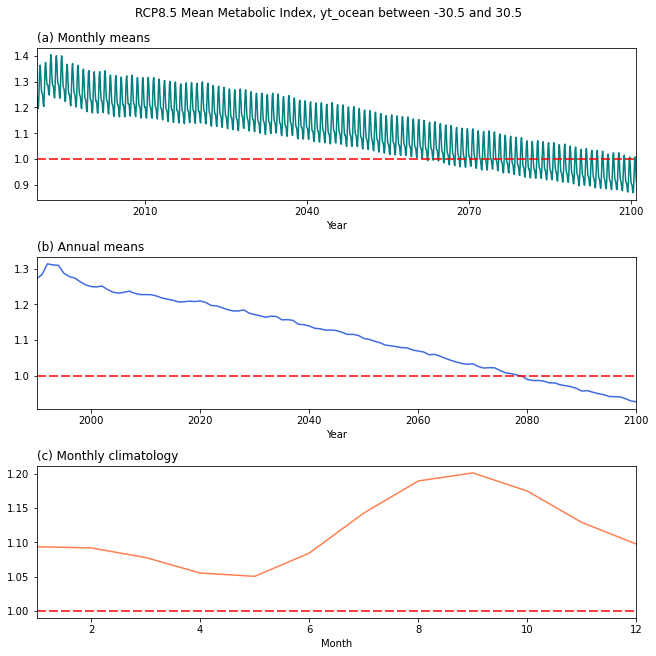

In [7]:
fig,(ax0,ax1,ax2) = plt.subplots(figsize=(9,9),nrows=3,constrained_layout=True)
fig.suptitle('RCP8.5 Mean Metabolic Index, yt_ocean between -30.5 and 30.5') # Specify a figure title
# Monthly means
ax0.plot(mi_mean['time'],mi_mean,color='teal')
ax0.set_title('(a) Monthly means',loc='left')
ax0.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax0.set_xlabel('Year')
ax0.axhline(y=1.0, xmin=0,xmax=1,color='red',dashes=[6,2])

# Annual means
ax1.plot(np.unique(mi_mean['time.year']),mi_mean.groupby('time.year').mean(),color='royalblue')
ax1.set_title('(b) Annual means',loc='left')
ax1.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax1.set_xlabel('Year')
ax1.axhline(y=1.0, xmin=0,xmax=1,color='red',dashes=[6,2])

# Monthly climatology
#   * use np.unique() to pick out an array of months
ax2.plot(np.unique(mi_mean['time.month']),mi_mean.groupby('time.month').mean(),color='coral')
ax2.set_title('(c) Monthly climatology',loc='left')
ax2.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax2.set_xlabel('Month')
ax2.axhline(y=1.0, xmin=0,xmax=1,color='red',dashes=[6,2])

In [8]:
def plot_year(start,end,plot,title):
    ds = ds_lim.sel(time=slice(start,end))
    mean_year = (ds['MI']*area_masked).sum(['xt_ocean','yt_ocean'])/(area_masked.sum(['xt_ocean','yt_ocean']))
    plot.plot(mean_year['time'],mean_year,color='teal')
    plot.set_title(title,loc='left')
    plot.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
    plot.set_xlabel('Year')
    plot.axhline(y=1.0, xmin=0,xmax=1,color='red',dashes=[6,2])
    plot.set_ylim(0.8,1.4)

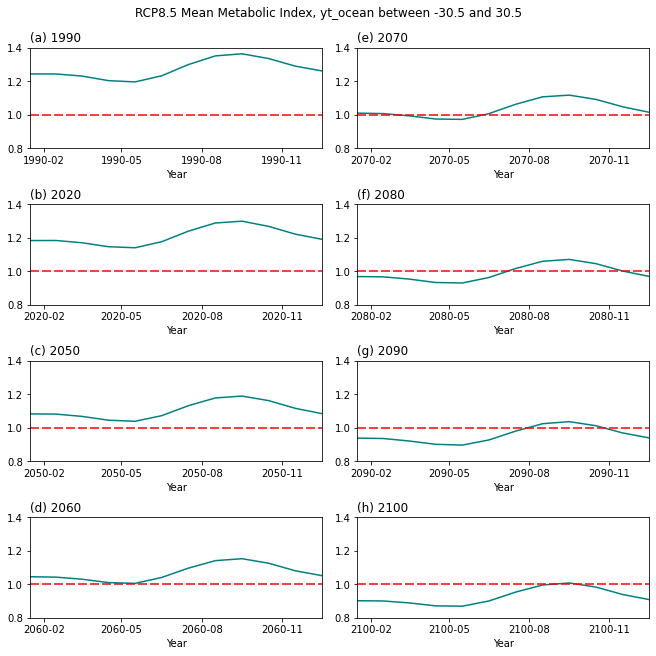

In [9]:
fig, axs = plt.subplots(figsize=(9,9),nrows=4,ncols=2,constrained_layout=True)
fig.suptitle('RCP8.5 Mean Metabolic Index, yt_ocean between -30.5 and 30.5') # Specify a figure title
plot_year('1990-01-01','1990-12-31',axs[0,0],'(a) 1990')
plot_year('2020-01-01','2020-12-31',axs[1,0],'(b) 2020')
plot_year('2050-01-01','2050-12-31',axs[2,0],'(c) 2050')
plot_year('2060-01-01','2060-12-31',axs[3,0],'(d) 2060')
plot_year('2070-01-01','2070-12-31',axs[0,1],'(e) 2070')
plot_year('2080-01-01','2080-12-31',axs[1,1],'(f) 2080')
plot_year('2090-01-01','2090-12-31',axs[2,1],'(g) 2090')
plot_year('2100-01-01','2100-12-31',axs[3,1],'(h) 2100')

Text(0.5, 1.0, 'Ensemble Average Global Metabolic Index May 2100, z0')

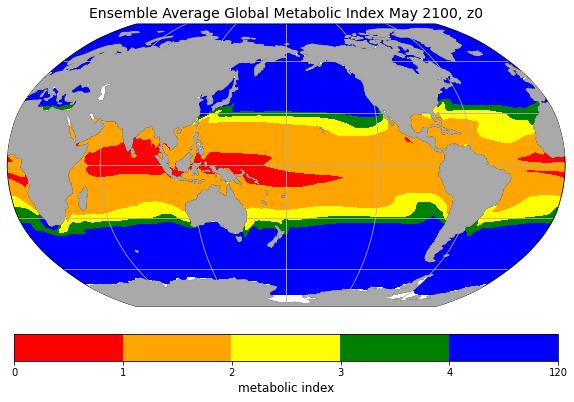

In [10]:
crs = ccrs.PlateCarree()
ds_may = ds_z0avg.sel(time=slice('2100-05-01','2100-05-31'))

fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

clevs = np.array([0,1,2,3,4,120])
colorange = ['red', 'orange', 'yellow','green','blue']

# Specify the longitude and latitude, and the variable that you wish to plot
X = ds_may['xt_ocean']
Y = ds_may['yt_ocean']
Z = ds_may['MI'].squeeze() # .squeeze() gets rid of unnecessary (singular) dimensions
# To overcome an issue with the discontinous nature of data in the x-dimension, use the add_cyclic_point function
Z, X = add_cyclic_point(Z,coord=X)

# Create a contour plot of SST
im = ax.contourf(X,Y,Z,clevs,colors=colorange,transform=crs)

cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('metabolic index',fontsize=12)

# Zoom in on a region
# ax.set_extent([120,180,-30,30])

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()

# Give your plot a title
ax.set_title('Ensemble Average Global Metabolic Index May 2100, z0',fontsize=14,loc='center')

In [16]:
def map_mi(data, start, end, plot, title):
    ds = data.sel(time=slice(start,end))
        
    clevs = np.array([0,1,2,3,4,120])
    colorange = ['red', 'orange', 'yellow','green','blue']
    crs = ccrs.PlateCarree()

    # Specify the longitude and latitude, and the variable that you wish to plot
    X = ds['xt_ocean']
    Y = ds['yt_ocean']
    Z = ds['MI'].squeeze() # .squeeze() gets rid of unnecessary (singular) dimensions
    # To overcome an issue with the discontinous nature of data in the x-dimension, use the add_cyclic_point function
    Z, X = add_cyclic_point(Z,coord=X)

    # Create a contour plot of SST
    im = plot.contourf(X,Y,Z,clevs,colors=colorange,transform=crs)
    
    if plot == axs[0,0]:
        cbar = plt.colorbar(im,ax=axs,orientation='horizontal',fraction=0.05,pad=0.05)
        cbar.set_label('metabolic index',fontsize=12)
    
    # Zoom in on a region
    plot.set_extent([40.5,120.5,-15.5,30.5])

    # Add a land mask to your plot, as well as grid lines and coastlines
    plot.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    plot.gridlines()
    plot.coastlines()

    # Give your plot a title
    plot.set_title(title,fontsize=14,loc='center')

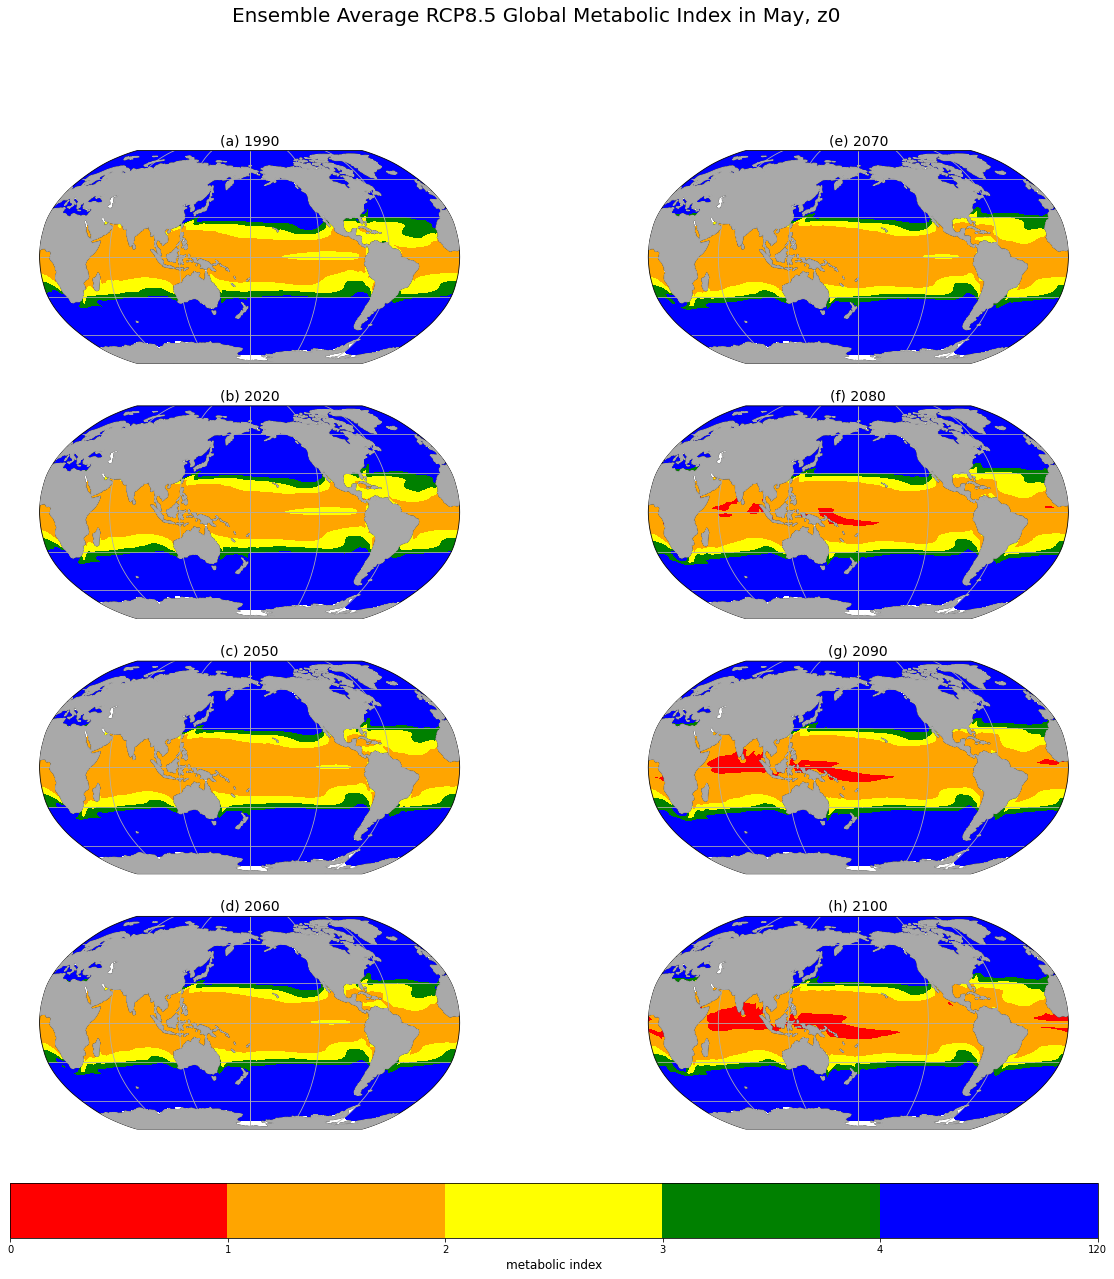

In [12]:
fig, axs = plt.subplots(figsize=(20,20),nrows=4,ncols=2, subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.suptitle('Ensemble Average RCP8.5 Global Metabolic Index in May, z0',fontsize=20) # Specify a figure title
map_mi(ds_z0avg,'1990-05-01','1990-05-31', axs[0,0], '(a) 1990')
map_mi(ds_z0avg,'2020-05-01','2020-05-31', axs[1,0], '(b) 2020')
map_mi(ds_z0avg,'2050-05-01','2050-05-31', axs[2,0], '(c) 2050')
map_mi(ds_z0avg,'2060-05-01','2060-05-31', axs[3,0], '(d) 2060')
map_mi(ds_z0avg,'2070-05-01','2070-05-31', axs[0,1], '(e) 2070')
map_mi(ds_z0avg,'2080-05-01','2080-05-31', axs[1,1], '(f) 2080')
map_mi(ds_z0avg,'2090-05-01','2090-05-31', axs[2,1], '(g) 2090')
map_mi(ds_z0avg,'2100-05-01','2100-05-31', axs[3,1], '(h) 2100')

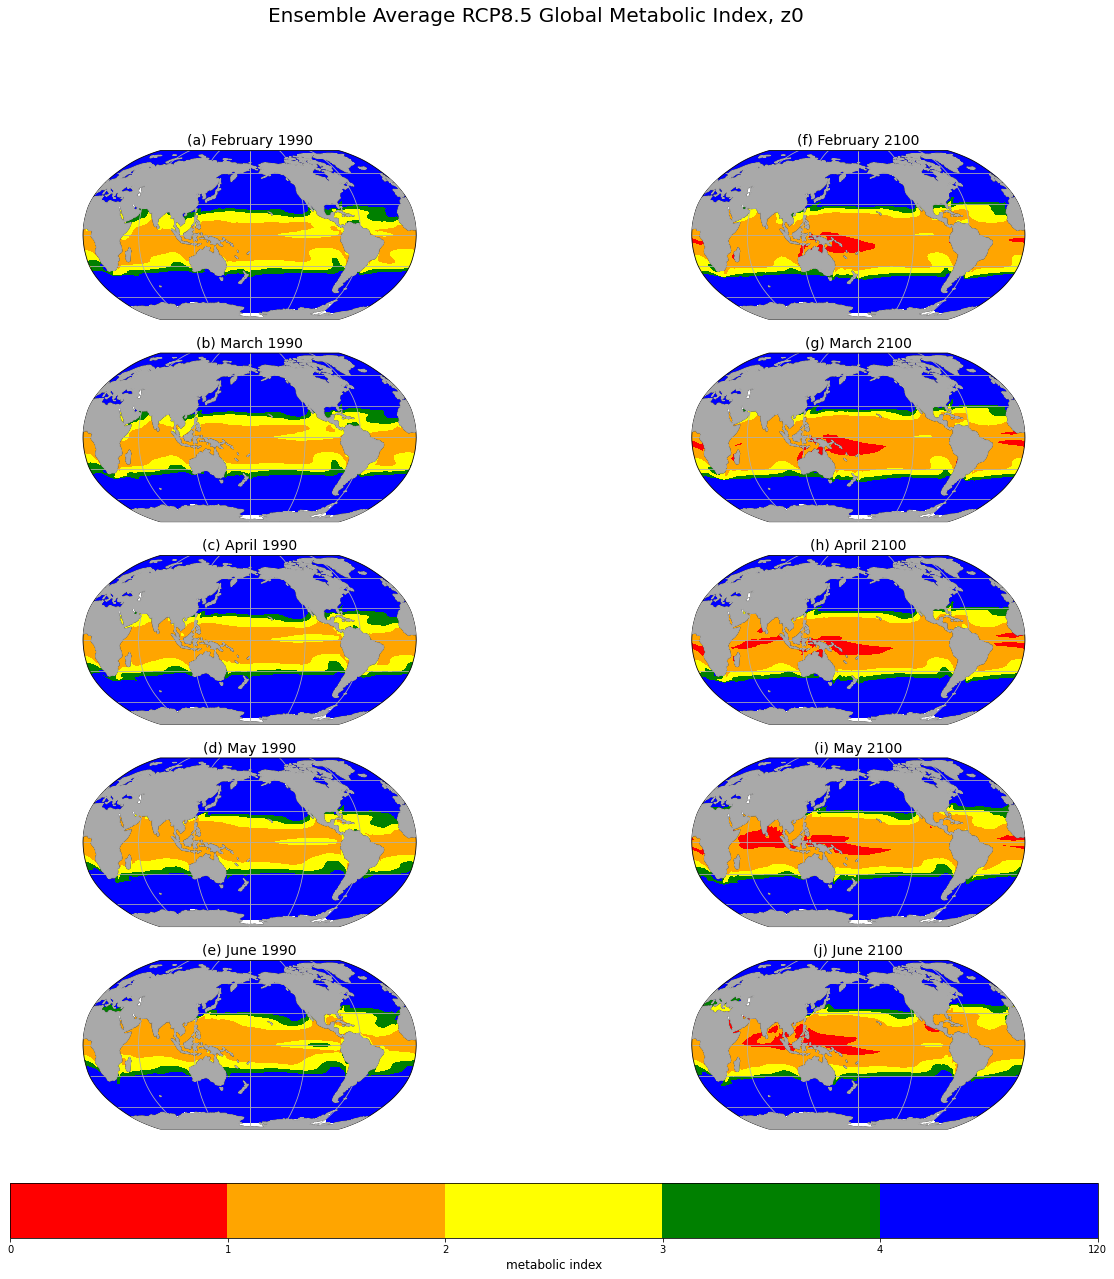

In [13]:
fig, axs = plt.subplots(figsize=(20,20),nrows=5,ncols=2, subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.suptitle('Ensemble Average RCP8.5 Global Metabolic Index, z0',fontsize=20) # Specify a figure title
map_mi(ds_z0avg,'1990-02-01','1990-02-28', axs[0,0], '(a) February 1990')
map_mi(ds_z0avg,'1990-03-01','1990-03-31', axs[1,0], '(b) March 1990')
map_mi(ds_z0avg,'1990-04-01','1990-04-30', axs[2,0], '(c) April 1990')
map_mi(ds_z0avg,'1990-05-01','1990-05-31', axs[3,0], '(d) May 1990')
map_mi(ds_z0avg,'1990-06-01','1990-06-30', axs[4,0], '(e) June 1990')
map_mi(ds_z0avg,'2100-02-01','2100-02-28', axs[0,1], '(f) February 2100')
map_mi(ds_z0avg,'2100-03-01','2100-03-31', axs[1,1], '(g) March 2100')
map_mi(ds_z0avg,'2100-04-01','2100-04-30', axs[2,1], '(h) April 2100')
map_mi(ds_z0avg,'2100-05-01','2100-05-31', axs[3,1], '(i) May 2100')
map_mi(ds_z0avg,'2100-06-01','2100-06-30', axs[4,1], '(j) June 2100')

In [14]:
def months_of_year(data,year):
    fig, axs = plt.subplots(figsize=(20,20),nrows=4,ncols=3, subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
    fig.suptitle('Ensemble Average RCP8.5 Global Metabolic Index '+year+', z0',fontsize=15) # Specify a figure title
    map_mi(data,year+'-01-01',year+'-01-31', axs[0,0], '(a) January')
    map_mi(data,year+'-02-01',year+'-02-28', axs[0,1], '(b) February')
    map_mi(data,year+'-03-01',year+'-03-31', axs[0,2], '(c) March')
    map_mi(data,year+'-04-01',year+'-04-30', axs[1,0], '(d) April')
    map_mi(data,year+'-05-01',year+'-05-31', axs[1,1], '(e) May')
    map_mi(data,year+'-06-01',year+'-06-30', axs[1,2], '(f) June')
    map_mi(data,year+'-07-01',year+'-07-31', axs[2,0], '(g) July')
    map_mi(data,year+'-08-01',year+'-08-31', axs[2,1], '(h) August')
    map_mi(data,year+'-09-01',year+'-09-30', axs[2,2], '(e) September')
    map_mi(data,year+'-10-01',year+'-10-30', axs[3,0], '(f) October')
    map_mi(data,year+'-11-01',year+'-11-30', axs[3,1], '(g) November')
    map_mi(data,year+'-12-01',year+'-12-31', axs[3,2], '(h) December')

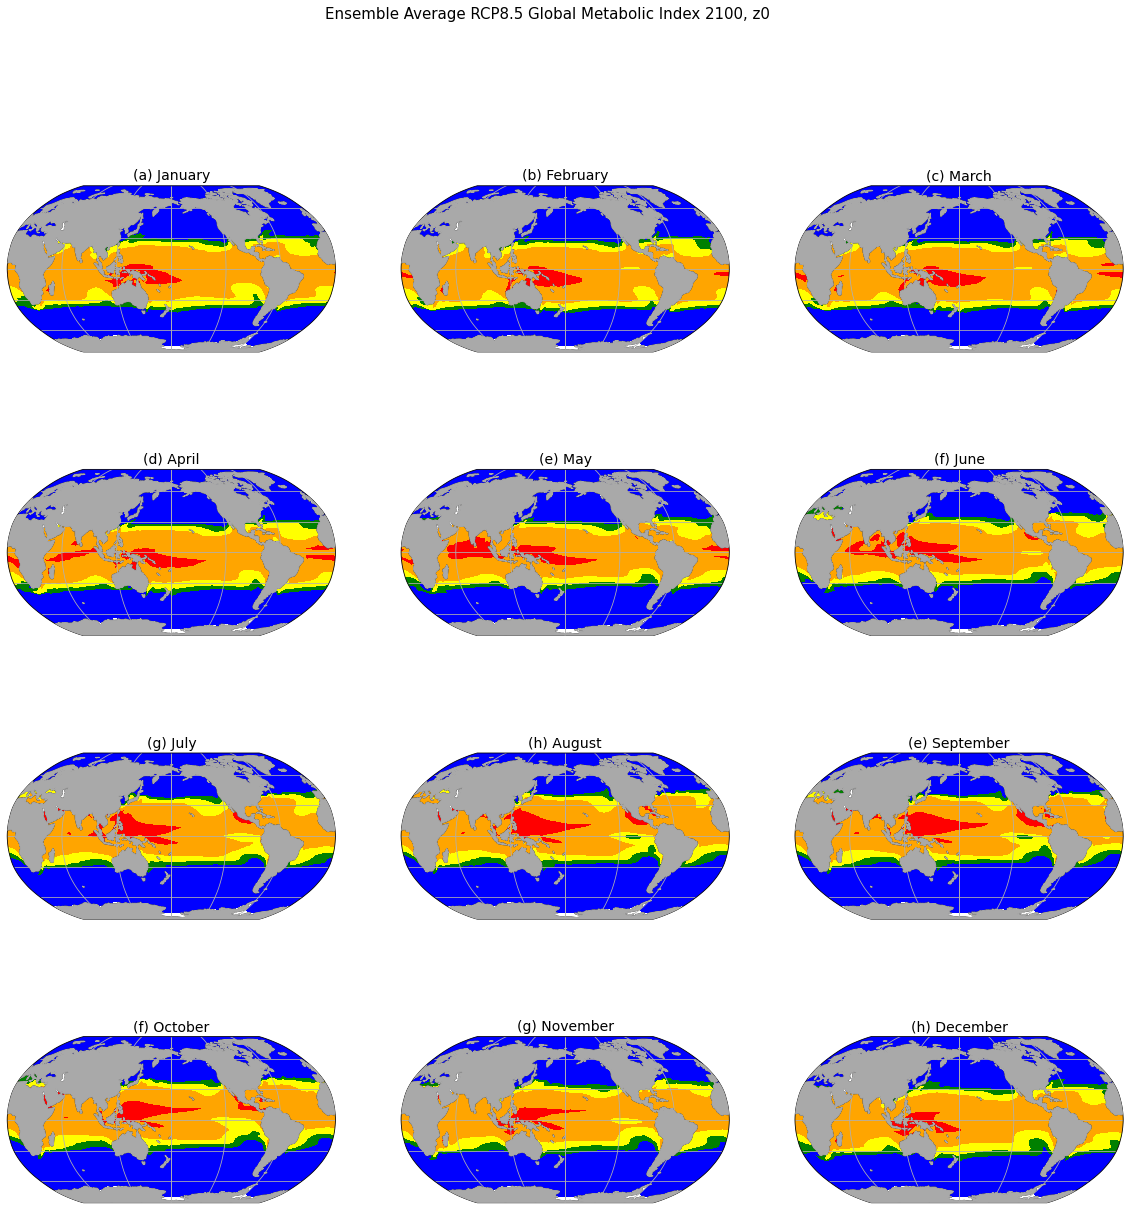

In [15]:
months_of_year(ds_z0avg,'2100')

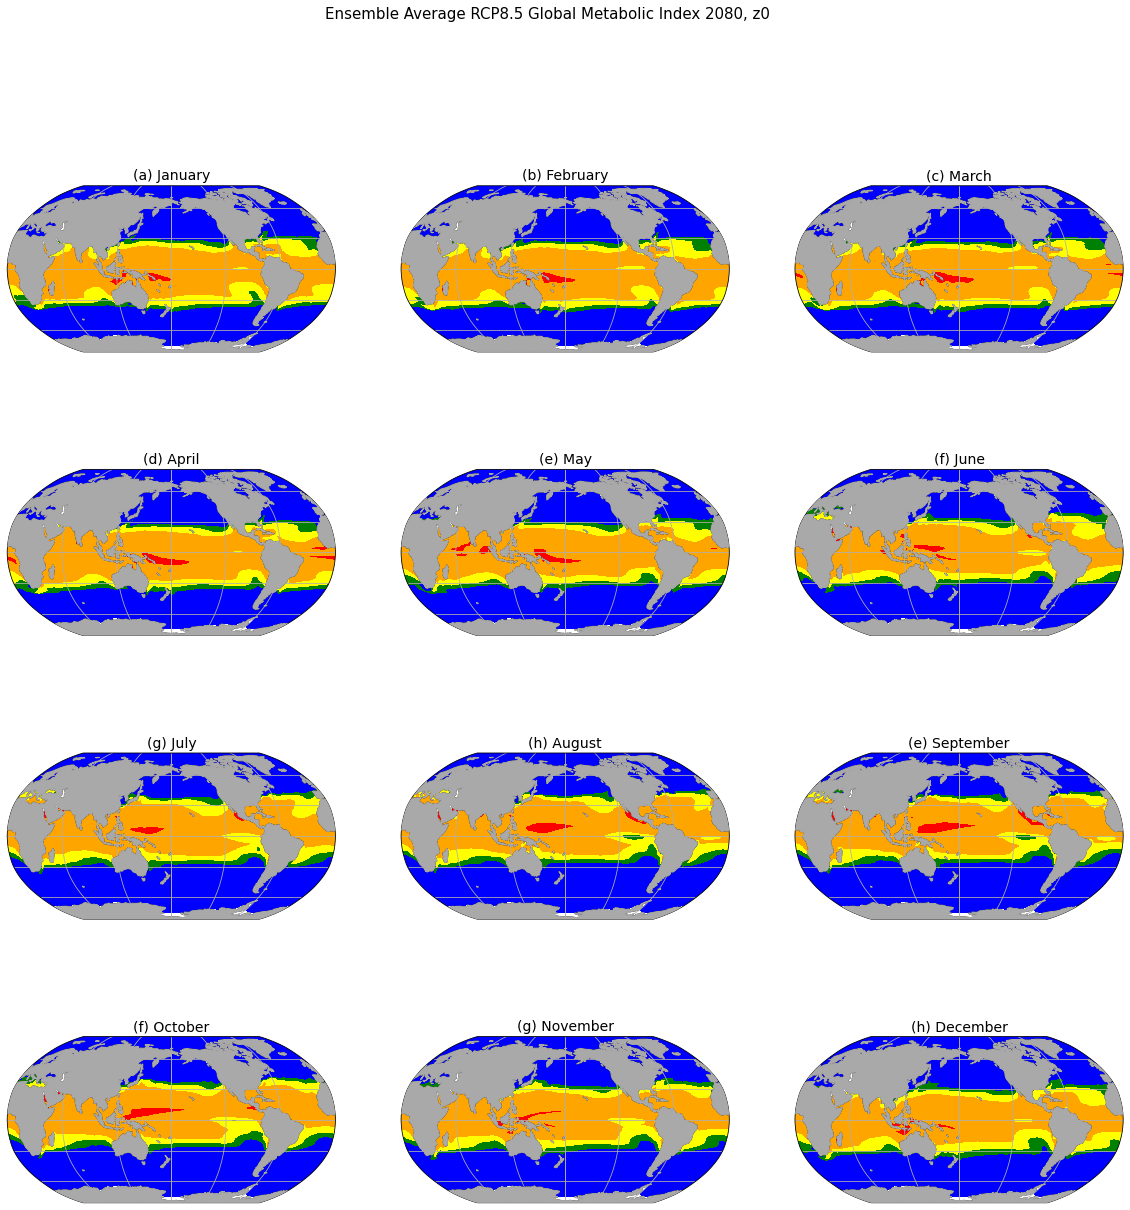

In [16]:
months_of_year(ds_z0avg,'2080')

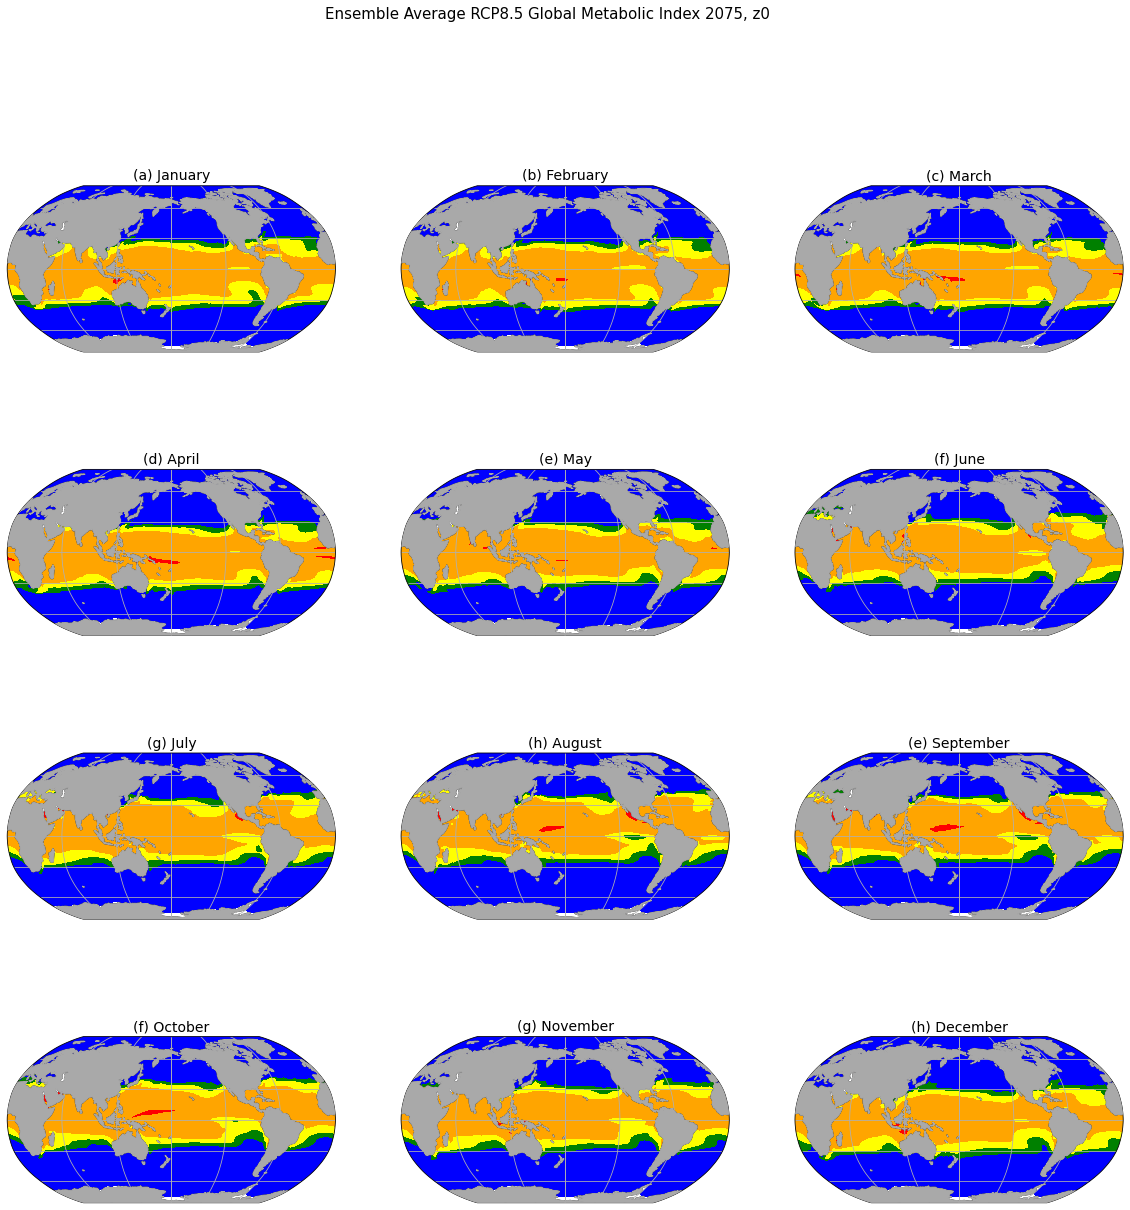

In [17]:
months_of_year(ds_z0avg,'2075')

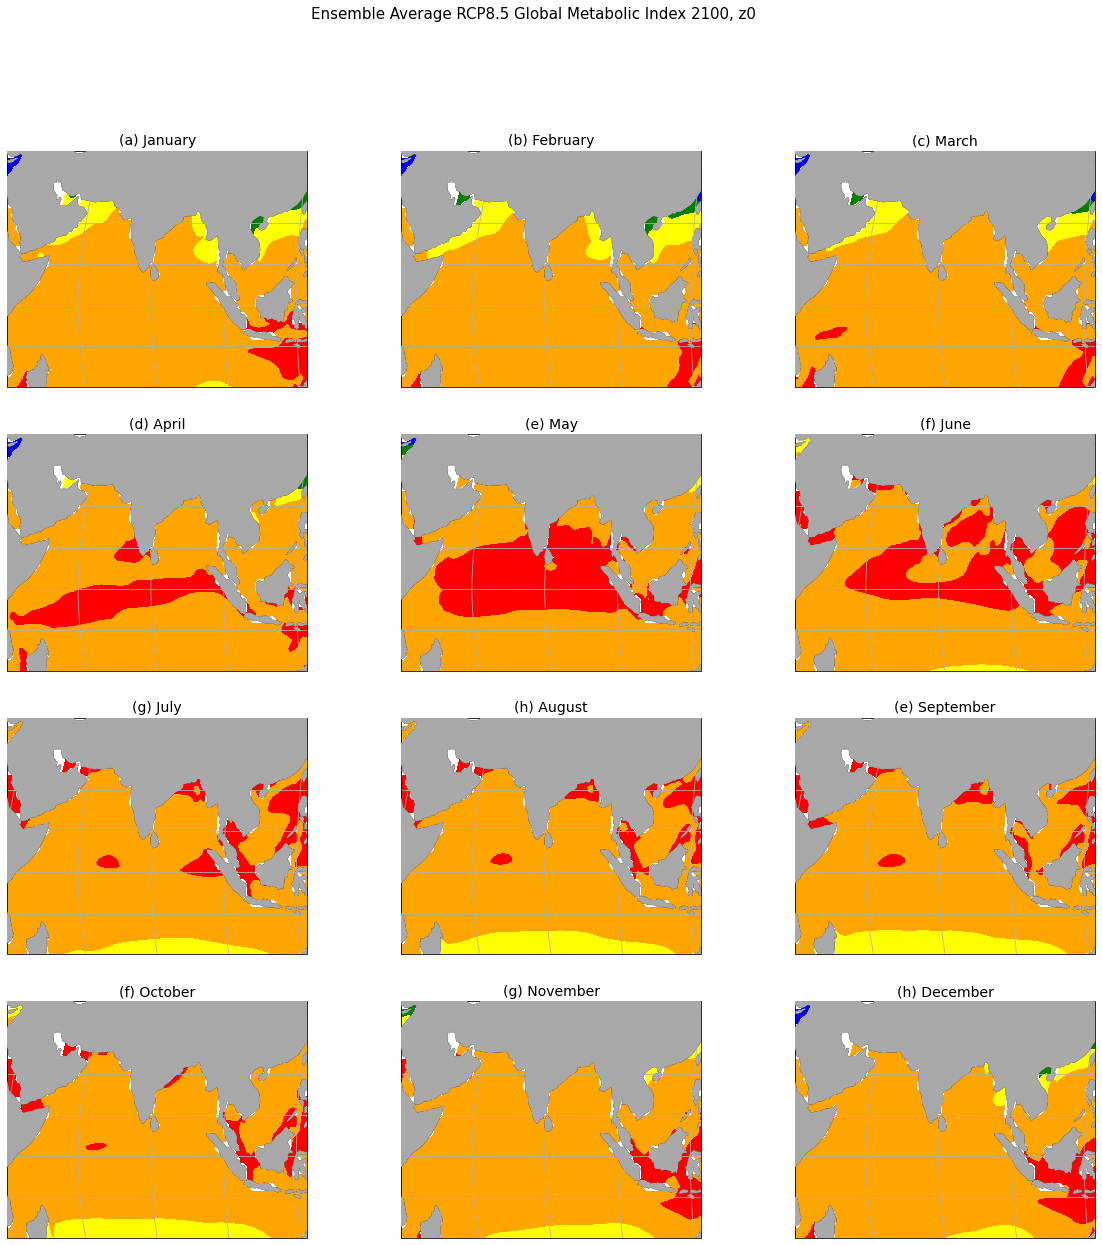

In [17]:
months_of_year(ds_z0avg,'2100')

In [ ]:
months_of_year(ds_z0avg,'2100')